In [28]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
import os
import sys

sns.set_style("white")
sns.set_palette("colorblind")

sys.path.insert(0, '/Users/angela/src/private/bias-in-datasets/active_learning/src')
import Evaluate
from Speedup import get_percent_speedup
from Plotter import format_plot_2ys

OURSYSTEM = "Selective-Backprop (Us)"
BASELINE = "Baseline"
RANDOM = "Random"
BASELINE_COLOR ="#009e73"
SB_COLOR = "#cc79a7"


In [29]:
class LineResult:
    def __init__(self, line_type, epoch, num_backprop, num_skip, loss, time, acc):
        self.line_type = line_type
        self.epoch = epoch
        self.num_backprop = num_backprop
        self.num_skip = num_skip
        self.loss = loss
        self.time = time
        self.acc = acc

    @property
    def is_train(self):
        return self.line_type == "train_debug"

    @property
    def is_test(self):
        return self.line_type == "test_debug"


def parse_line_v1(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[4])
        time = float(vals[5])
        acc = float(vals[6])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[3])
        acc = float(vals[4])
        time = float(vals[5])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, loss, time, acc)


def parse_line_v2(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[5])
        time = float(vals[6])
        acc = float(vals[7])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[4])
        acc = float(vals[5])
        time = float(vals[6])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, num_skipped, loss, time, acc)


def parser_for(filename):
    version = filename.split('_')[-1]
    if version == "v1":
        return parse_line_v1
    if version == "v2":
        return parse_line_v2
    if version == "v3":
        return parse_line_v2
    else:
        Exception("Version cannot be {}".format(version))


def parse_file(filename):
    parser = parser_for(filename)
    with open(filename) as f:
        parsed = [parser(line)
                  for line in f]
    return ([d for d in parsed if d and d.is_train],
            [d for d in parsed if d and d.is_test])



In [30]:
class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)(_seed\d+)?")
    def __init__(self, filename, experiment_name):
        print(filename)

        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = groups[6]
        self.seed = None
        self.experiment_name = experiment_name
        unparsed_trial = groups[7]
        self.trial = int(unparsed_trial.strip("_trial"))
        if groups[8]:
            unparsed_seed = groups[8]
            self.seed = int(unparsed_seed.strip("_seed"))
            
    @property
    def label(self):
        if self.strategy == "topk":
            label = "{}, {}, {}, top_{}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.pool_size),
                                                      self.lr)
        elif self.strategy == "lowk":
            label = "{}, {}, {}, lowest_{}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.pool_size),
                                                      self.lr)
        elif self.strategy == "randomk":
            label = "{}, {}, {}, random_{}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.pool_size),
                                                      self.lr)
        elif self.strategy in ["kath-baseline", "kath-biased", "kath-reweighted"]:
            label = "{}, {}, {}, {}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.pool_size),
                                                      self.lr)
        elif self.strategy == "sampling" or self.strategy == "deterministic":
            label = "{}, {}, {}, Min: {}".format(self.experiment_name,
                                                   self.strategy,
                                                   self.network,
                                                   self.top_k) 
        elif self.strategy == "baseline":
            label = "{}, {}, {}".format(self.experiment_name,
                                                   self.strategy,
                                                   self.network) 
        elif self.strategy == "kuangliu":
            label = "{}, original".format(self.experiment_name) 
        elif self.strategy == "debug":
            label = "{}, debug".format(self.experiment_name) 

        #if self.seed:
        #    label += ", seed-{}".format(self.seed)
        #else:
        #    label += ", trial-{}".format(self.trial)
        return label
            
    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()
    
def write_file(plot_file_prefix, show=False):

    plot_file = "{}.pdf".format(plot_file_prefix)
    plt.savefig(plot_file)
    
    print(plot_file)
    
    plot_file = "{}.png".format(plot_file_prefix)
    plt.savefig(plot_file, format="png", dpi=1000)
    
    if show:
        plt.show()
        
    plt.clf()

def format_plot(xlabel, ylabel, label_size=10, grid=False):
    plt.tick_params(axis='y', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='y', which='minor', labelsize=label_size * 1.2)
    plt.tick_params(axis='x', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='x', which='minor', labelsize=label_size * 1.2)

    plt.xlabel(xlabel, fontsize=label_size * 1.6)
    plt.ylabel(ylabel, fontsize=label_size * 1.6)
    plt.tight_layout()
    plt.gca().xaxis.grid(grid)
    plt.gca().yaxis.grid(grid)
    
    leg = plt.legend(loc=0, prop={'size': label_size * .6})
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)


In [31]:

def plot(xs_by_config,
         ys_by_config,
         xlabel, ylabel,
         plot_dir,
         smoothing=0,
         lw=1,
         ymin=None,
         ymax=None,
         xmax=None,
         ymarker=None,
         ylog=False,
         annotate_accuracy=False,
         target_errors=None):
    local_xmax = - float("inf")
    local_ymax = - float("inf")
    for config, ys in sorted(ys_by_config.iteritems(), key=lambda x: x[0].top_k):
        if len(ys) == 0:
            print "No elements for {} in {}".format(config.label, ylabel)
            continue
            
        xs = xs_by_config[config]

        for i in range(smoothing):
            xs = [(l+r) / 2. for l, r in zip(xs[:-1], xs[1:])]
            ys = [(l+r) / 2. for l, r in zip(ys[:-1], ys[1:])]
        
        #TODO get label here
        label = config.label
        if annotate_accuracy:
            label += ", Acc:{}".format(max(ys))

        if config.top_k == config.pool_size or config.top_k == 1:
            plt.plot(xs, ys, label=label, linestyle="--", linewidth=lw, alpha=0.7, zorder=0)
        else:
            plt.plot(xs, ys, label=label, linewidth=lw, alpha=0.9, zorder=0)

        if max(xs) > local_xmax:
            local_xmax = max(xs)
        if max(ys) > local_ymax:
            local_ymax = max(ys)
        if xmax:
            plt.xlim(0, xmax)
        if ymin is not None:
            if ymax is not None:
                plt.ylim(ymin, ymax)
            else:
                plt.ylim(ymin, local_ymax)

        
        # Add visual marker where we achieve ymarker accuracy      
        xmarker = Evaluate.find_first_x_at_y(xs, ys, ymarker)
        if xmarker:
            print("xmarker: ", xmarker)
            plt.scatter([xmarker], [ymarker], marker="*", s=50, color="black", zorder=1)
            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
    if len(ys_by_config.keys()) > 0:
        plot_prefix = "{}/{}_{}".format(plot_dir,
                                        xlabel,
                                        ylabel).replace(" ", "-")
        if ylog:
            plt.yscale("log")
        format_plot(xlabel, ylabel)
        
        if target_errors:
            for target_error in target_errors:
                plt.axhline(y=target_error, color='gray', linestyle=':', linewidth=0.2)
        write_file(plot_prefix, show=True)




In [32]:
def make_instantaneous(l):
    lcopy = l[:]
    lcopy.insert(0, 0)        
    pairs = zip(lcopy[::1], lcopy[1::1])
    ilist = [j - i for i, j in pairs]
    return ilist

def smooth(l, constant):
    for i in range(constant):
        l = [(l+r) / 2. for l, r in zip(l[:-1], l[1:])]
    return l
            
def plot_experiments(experiment_names,
                     experiments_dir,
                     plot_dir,
                     lrs=None,
                     nets=None,
                     trials=None,
                     sampling_mins=None,
                     smoothing=0,
                     xmax=None,
                     ymin=None,
                     ymax=None,
                     ymarker=None,
                     strategies=None,
                     target_errors = None):
    
    train_num_backprops_by_config = {}
    test_num_backprops_by_config = {}
    test_num_inferences_by_config = {}
    train_losses_by_config = {}
    test_losses_by_config = {}
    test_errors_by_config = {}
    train_accuracies_by_config = {}
    test_accuracies_by_config = {}
    train_accuracies_by_config = {}
    ratio_backpropped_by_config_xs = {}
    ratio_backpropped_by_config_ys = {}

    for experiment_name in experiment_names:
        experiment_dir = os.path.join(experiments_dir, experiment_name)
        for filename in os.listdir(experiment_dir):
            if filename == ".DS_Store" or filename == "pickles" or filename == "sha":
                continue
                
            print(filename)

            filepath = os.path.join(experiment_dir, filename)
            config = Config(filename, experiment_name)
            train_lines, test_lines = parse_file(filepath)
            
            if lrs and config.lr not in lrs:
                continue
            if nets and config.network not in nets:
                continue
            if trials and config.trial not in trials:
                continue
            if sampling_mins and config.top_k not in sampling_mins:
                continue
            if strategies and config.strategy not in strategies:
                continue

            train_num_backprops = [l.num_backprop / 1000000. for l in train_lines]
            test_num_backprops = [l.num_backprop / 1000000. for l in test_lines]
            test_num_inferences = [(l.num_backprop + l.num_skip) / 1000000. for l in test_lines]
            train_num_inferences = [(l.num_backprop + l.num_skip) / 1000000. for l in train_lines]

            instantaneous_train_num_backprops = make_instantaneous(train_num_backprops)
            instantaneous_train_num_inferences = make_instantaneous(train_num_inferences)

            train_losses = [l.loss for l in train_lines]
            test_losses = [l.loss for l in test_lines]
            train_accuracies = [l.acc for l in train_lines]
            test_accuracies = [l.acc for l in test_lines]
            test_errors = [100-l.acc for l in test_lines]
            
            ratio_backpropped_ys = smooth([x / float(y) \
                                           for x, y in zip(instantaneous_train_num_backprops,
                                                           instantaneous_train_num_inferences)
                                           if y > 0], 10)
            ratio_backpropped_xs = smooth([l.num_backprop / 1000000. \
                                           for l in train_lines \
                                           if (l.num_backprop + l.num_skip) > 0], 10)
            
            train_num_backprops_by_config[config] = train_num_backprops
            test_num_backprops_by_config[config] = test_num_backprops
            test_num_inferences_by_config[config] = test_num_inferences
            train_losses_by_config[config] = train_losses
            test_losses_by_config[config] = test_losses
            train_accuracies_by_config[config] = train_accuracies
            test_accuracies_by_config[config] = test_accuracies
            test_errors_by_config[config] = test_errors
            ratio_backpropped_by_config_xs[config] = ratio_backpropped_xs
            ratio_backpropped_by_config_ys[config] = ratio_backpropped_ys


    plot(ratio_backpropped_by_config_xs, ratio_backpropped_by_config_ys, "Num Images Backpropped (millions)", "Ratio Backpropped", plot_dir, smoothing, lw=0.8, ymin=0, xmax=xmax)
    #plot(train_num_backprops_by_config, train_losses_by_config, "Num Images Backpropped (millions)", "Training Loss", plot_dir, smoothing, lw=1, xmax=xmax)
    plot(test_num_backprops_by_config, test_accuracies_by_config, "Num Images Backpropped (millions)", "Test Accuracy", plot_dir, smoothing, lw=1, ymin=ymin, ymax=ymax, xmax=xmax, ymarker=ymarker, annotate_accuracy=True)
    plot(test_num_backprops_by_config, test_errors_by_config, "Num Images Backpropped (millions)", "Test Error", plot_dir, smoothing, lw=1, ymin=ymin, ymax=ymax, xmax=xmax,  ymarker=ymarker, ylog=True, target_errors=target_errors)
    plot(test_num_inferences_by_config, test_errors_by_config, "Num Images Forward Propped (millions)", "Test Error", plot_dir, smoothing, lw=1, ymin=ymin, ymax=ymax, xmax=xmax, ymarker=ymarker, ylog=True, target_errors=target_errors)
    plot(test_num_backprops_by_config, test_losses_by_config, "Num Images Backpropped (millions)", "Test Loss", plot_dir, smoothing, lw=1, xmax=xmax)

In [33]:
def plot_percent_speedup(plot_dir, title, nb0, nb1s, nf1s, labels, max_alpha):
    plot_prefix = "{}/{}".format(plot_dir, title)
    if nb0 is None:
        print("Baseline has not reached target error")
        return
    for nb1, nf1, label in zip(nb1s, nf1s, labels):
        if nb1 is None:
            continue
        ys = []
        alphas = range(1, max_alpha + 1)
        for alpha in alphas:
            y = get_percent_speedup(nb0, nb1, nf1, alpha)
            ys.append(y)
        plt.plot(alphas, ys, label=label)

    format_plot("Ratio of Backwards to Forwards Pass Latency", "Speedup Factor")
    write_file(plot_prefix)



In [34]:
def plot_final_error_tradeoff(plot_dir, errors, forwards, labels):
    plot_prefix = "{}/{}".format(plot_dir, "final-error-forwards")
    fig, ax = plt.subplots()
    ax.scatter(forwards, errors)
    for i, txt in enumerate(labels):
        ax.annotate(txt, (forwards[i], errors[i]))
    format_plot("Total # Forwards (millions)", "Final Error")
    ax.set_xlim(left=0)
    write_file(plot_prefix, show=True)

In [35]:
def plot_passes_by_target(plot_dir,
                          nb0s,
                          nb1s,
                          nf1s,
                          labels,
                          targets):
    backwards_by_line = {}
    forwards_by_line = {}
    xs_by_line = {}
    
    backwards_by_line["Baseline"] = []
    forwards_by_line["Baseline"] = []
    xs_by_line["Baseline"] = []
    
    for target in reversed(targets):
        nb0 = nb0s[target]
        
        backwards_by_line["Baseline"].append(nb0)
        forwards_by_line["Baseline"].append(nb0)
        xs_by_line["Baseline"].append(target)

        if nb0 is None:
            continue

        for nb1, nf1, label in zip(nb1s[target], nf1s[target], labels):
            if nb1 is None:
                continue
            if label not in backwards_by_line.keys():
                backwards_by_line[label] = []
                forwards_by_line[label] = []
                xs_by_line[label] = []
            backwards_by_line[label].append(nb1)
            forwards_by_line[label].append(nf1)
            xs_by_line[label].append(target)

    for ys_dict, y_label in zip([backwards_by_line, forwards_by_line],
                                ["Backwards Passes", "Forwards Passes"]):
        max_x = 0
        min_x = float('Inf')
        for label, ys in ys_dict.iteritems():
            xs = xs_by_line[label]
            plt.plot(xs, ys, label=label)
        if max(xs) > max_x:
            max_x = max(xs)
        if min(xs) < min_x:
            min_x = min(xs)
        plt.axhline(y=0, color='gray', linestyle=':', linewidth=1)
        format_plot("Target Error", y_label)
        plot_prefix = "{}/target-vs-{}".format(plot_dir, y_label)
        plt.xlim(max_x, min_x)
        write_file(plot_prefix)
        plt.clf()

In [36]:
def plot_percent_speedup_by_alphas(plot_dir, label_idx, label, nb0s, nb1s, nf1s, targets, kath_selectivity=None, alphas=[2,10]):
    max_y = 0
    for alpha in alphas:
        xs = []
        ys = []

        for target in reversed(targets):
            nb0 = nb0s[target]
            if nb0 is None:
                continue
            nb1 = nb1s[target][label_idx]
            nf1 = nf1s[target][label_idx]
            if nb1 is None:
                continue
            y = get_percent_speedup(nb0, nb1, nf1, alpha, kath_selectivity)
            xs.append(target)
            ys.append(y)
            
        if max(ys) > max_y:
            max_y = max(ys)
        plt.plot(xs, ys, marker='o', label="Backwards is {}X More costly".format(alpha))
        if alpha == 2 or alpha == 10:
            print("{} targets: {}-{}".format(label, min(xs), max(xs),2))
            print("{} @ {}X {}-{}".format(label, alpha, round(min(ys),2), round(max(ys),2)))
        
    format_plot("Target Error", "Speedup Factor")
    plt.xlim(max(targets), min(targets))
    plt.ylim(0, int(max_y) + 1)
    plot_prefix = "{}/{}".format(plot_dir, "speedups{}".format(label))
    write_file(plot_prefix)

In [37]:

def plot_percent_speedup_by_alpha(plot_dir,
                                  title,
                                  nb0s,
                                  nb1s,
                                  nf1s,
                                  labels,
                                  targets,
                                  alpha):
    speedups_by_line = {}
    xs_by_line = {}

    for target in reversed(targets):
        nb0 = nb0s[target]
        if nb0 is None:
            continue
        for nb1, nf1, label in zip(nb1s[target], nf1s[target], labels):
            if nb1 is None:
                continue
            if label not in speedups_by_line.keys():
                speedups_by_line[label] = []
                xs_by_line[label] = []
            y = get_percent_speedup(nb0, nb1, nf1, alpha)
            speedups_by_line[label].append(y)
            xs_by_line[label].append(target)

    max_x = 0
    min_x = float('Inf')
    for label, ys in speedups_by_line.iteritems():
        xs = xs_by_line[label]
        plt.plot(xs, ys, label=label)
        if max(xs) > max_x:
            max_x = max(xs)
        if min(xs) < min_x:
            min_x = min(xs)
    plt.axhline(y=0, color='gray', linestyle=':', linewidth=1)
    format_plot("Target Error", "Speedup Factor")
    plt.xlim(max_x, min_x)
    plot_prefix = "{}/{}".format(plot_dir, title)
    write_file(plot_prefix)
        

In [38]:
# Glue for plot_final_error_tradeoff and plot_percent_speedup

def plot_wallclock(plot_dir,
                   target_errors,
                   experimental_names,
                   baseline_name,
                   experimental_labels,
                   final_bp,
                   max_alpha,
                   kath_selectivities):
    
    nb0s = {}
    nb1s = {}
    nf1s = {}

    final_errors = []
    final_nfs = []
    final_labels = []

    # Experimental
    for experimental_name, experimental_label in zip(experimental_names, experimental_labels):
        print("----------{} Error ---------------".format(experimental_label))
        data = Evaluate.evaluate_file(experimental_name, target_errors, [final_bp])
        for target_error in target_errors:
            if target_error not in nb1s.keys():
                nb1s[target_error] = []
                nf1s[target_error] = []
            nb1s[target_error].append(data["target_errors"][target_error]["num_backwards"])
            nf1s[target_error].append(data["target_errors"][target_error]["num_forwards"])
        final_error = data["target_backwards"][final_bp]["error"]
        if final_error:
            final_errors.append(final_error)
            final_labels.append(experimental_label)
            final_nfs.append(data["target_backwards"][final_bp]["num_forwards"])
            #print("{} final error at {}bps: {}".format(experimental_label, final_bp, round(final_error, 2)))
        
    # Baseline
    print("----------{} Baseline Error ---------------".format(experimental_label))
    data = Evaluate.evaluate_file(baseline_name, target_errors, [final_bp])
    for target_error in target_errors:
        nb0s[target_error] = data["target_errors"][target_error]["num_backwards"]
    final_error = data["target_backwards"][final_bp]["error"]
    if final_error:
        final_errors.append(final_error)
        final_labels.append("Baseline")
        final_nfs.append(data["target_backwards"][final_bp]["num_forwards"])
    
    # Plot final error
    #plot_final_error_tradeoff(plot_dir, final_errors, final_nfs, final_labels)
    
    # Plot forwards/backwards by target error
    #plot_passes_by_target(plot_dir, nb0s, nb1s, nf1s, experimental_labels, target_errors)
    
    # Plot speedup by cost_ratio
    '''
    for alpha in range(max_alpha):
        title = "alpha{}".format(alpha)
        plot_percent_speedup_by_alpha(plot_dir,
                                      title,
                                      nb0s,
                                      nb1s,
                                      nf1s,
                                      experimental_labels,
                                      target_errors,
                                      alpha)
    '''
        
    for i, (label, ks) in enumerate(zip(experimental_labels, kath_selectivities)):
        print("----------{} Speedup ---------------".format(label))
        plot_percent_speedup_by_alphas(plot_dir, i, label, nb0s, nb1s, nf1s, target_errors, ks)


In [39]:
def plot_percentiles(plot_dir, files, labels, colors):
    indices = [1, 2]
    ylabels = ["Target Confidence", "Percent Correct"]
    for index, ylabel in zip(indices, ylabels):
        for fname, label, color in zip(files, labels, colors):
            xs = []
            ys = []
            with open(fname) as f:
                for line in f:
                    vals = line.rstrip().split(",")
                    x = float(vals[0])
                    y = float(vals[index])
                    xs.append(x)
                    ys.append(y)
            plt.plot(xs, ys, label=label, color=color)
        format_plot("Percentile", ylabel)
        subplot_dir = os.path.join(plot_dir, ylabel)
        write_file(subplot_dir)
    

=====================0========================
kath-baseline_cifar10_mobilenetv2_1_128_512_0.0005_trial1_seed1337_v2
kath-baseline_cifar10_mobilenetv2_1_128_512_0.0005_trial1_seed1337_v2
kath-biased_cifar10_mobilenetv2_1_128_512_0.0005_trial1_seed1337_v2
kath-biased_cifar10_mobilenetv2_1_128_512_0.0005_trial1_seed1337_v2
kath-reweighted_cifar10_mobilenetv2_1_128_1024_0.0005_trial1_seed1337_v2
kath-reweighted_cifar10_mobilenetv2_1_128_1024_0.0005_trial1_seed1337_v2
kath-reweighted_cifar10_mobilenetv2_1_128_512_0.0005_trial1_seed1337_v2
kath-reweighted_cifar10_mobilenetv2_1_128_512_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenetv2_0_128_1024_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenetv2_0_128_1024_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenetv2_1_128_1024_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenetv2_1_128_1024_0.0005_trial1_seed1337_v2
topk_cifar10_mobilenetv2_0_128_32_0.0005_trial1_seed1337_v2
topk_cifar10_mobilenetv2_0_128_32_0.0005_trial1_seed1337_v2
../

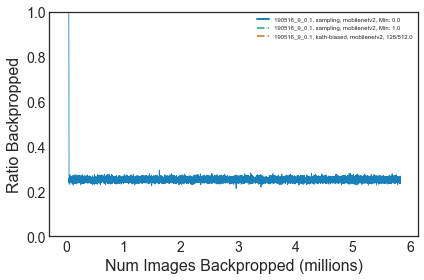

../plots/neurips//static_lr/cifar10//Num-Images-Backpropped-(millions)_Test-Accuracy.pdf


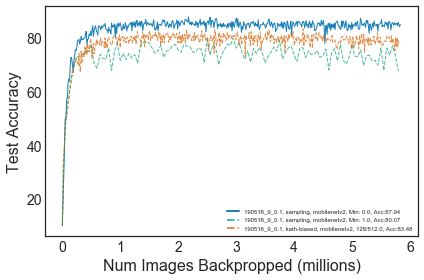

../plots/neurips//static_lr/cifar10//Num-Images-Backpropped-(millions)_Test-Error.pdf


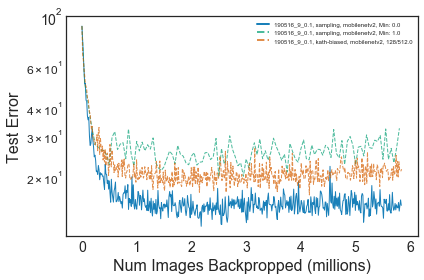

../plots/neurips//static_lr/cifar10//Num-Images-Forward-Propped-(millions)_Test-Error.pdf


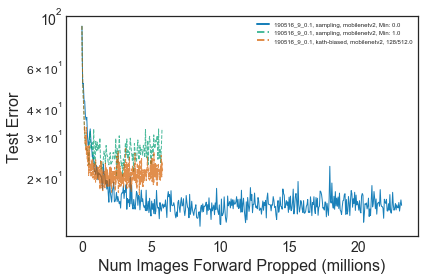

../plots/neurips//static_lr/cifar10//Num-Images-Backpropped-(millions)_Test-Loss.pdf


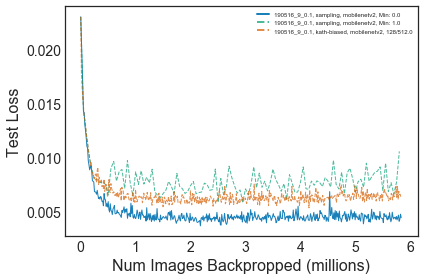

----------Baseline Error ---------------
Final error: 19.93, Forwards: 2.5, Backwards: 2.5
----------Kath-Biased Error ---------------
Final error: 16.52, Forwards: 4.155776, Backwards: 4.155776
----------SB Error ---------------
Final error: 12.06, Forwards: 8.55, Backwards: 2.178697
----------SB Baseline Error ---------------
Final error: 19.93, Forwards: 2.5, Backwards: 2.5
----------Baseline Speedup ---------------
Baseline targets: 20-20
Baseline @ 2X 1.0-1.0
Baseline targets: 20-20
Baseline @ 10X 1.0-1.0
../plots/neurips//static_lr/cifar10//speedupsBaseline.pdf
----------Kath-Biased Speedup ---------------
Kath-Biased targets: 20-20
Kath-Biased @ 2X 1.13-1.13
Kath-Biased targets: 20-20
Kath-Biased @ 10X 2.31-2.31
../plots/neurips//static_lr/cifar10//speedupsKath-Biased.pdf
----------SB Speedup ---------------
SB targets: 20-20
SB @ 2X 4.17-4.17
SB targets: 20-20
SB @ 10X 6.25-6.25
../plots/neurips//static_lr/cifar10//speedupsSB.pdf
=====================1========================
k

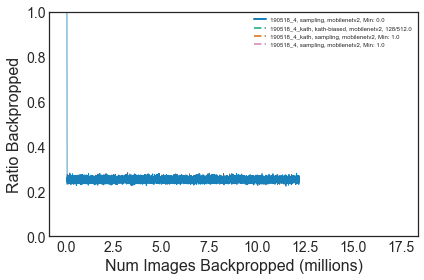

../plots/neurips//forwardlr_slow/cifar10//Num-Images-Backpropped-(millions)_Test-Accuracy.pdf


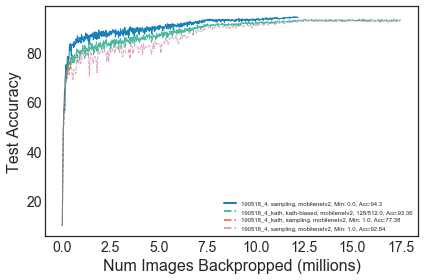

../plots/neurips//forwardlr_slow/cifar10//Num-Images-Backpropped-(millions)_Test-Error.pdf


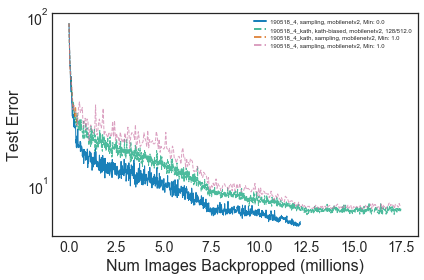

../plots/neurips//forwardlr_slow/cifar10//Num-Images-Forward-Propped-(millions)_Test-Error.pdf


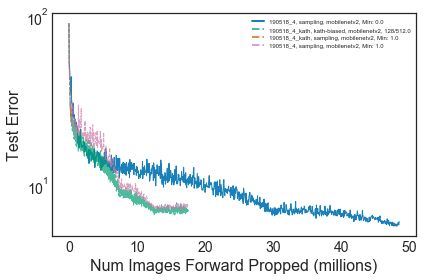

../plots/neurips//forwardlr_slow/cifar10//Num-Images-Backpropped-(millions)_Test-Loss.pdf


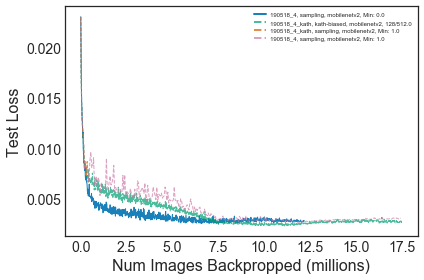

----------Baseline Error ---------------
Final error: 7.16, Forwards: 16.35, Backwards: 16.35
----------SB Error ---------------
Final error: 5.7, Forwards: 47.75, Backwards: 11.998367
----------Kath-Biased Error ---------------
Final error: 6.64, Forwards: 15.512576, Backwards: 15.512576
----------Kath-Biased Baseline Error ---------------
Final error: 7.16, Forwards: 16.35, Backwards: 16.35
----------Baseline Speedup ---------------
Baseline targets: 11-21
Baseline @ 2X 1.0-1.0
Baseline targets: 11-21
Baseline @ 10X 1.0-1.0
../plots/neurips//forwardlr_slow/cifar10//speedupsBaseline.pdf
----------SB Speedup ---------------
SB targets: 11-21
SB @ 2X 1.56-4.41
SB targets: 11-21
SB @ 10X 2.34-6.67
../plots/neurips//forwardlr_slow/cifar10//speedupsSB.pdf
----------Kath-Biased Speedup ---------------
Kath-Biased targets: 11-21
Kath-Biased @ 2X 0.63-1.75
Kath-Biased targets: 11-21
Kath-Biased @ 10X 0.99-2.75
../plots/neurips//forwardlr_slow/cifar10//speedupsKath-Biased.pdf


<Figure size 432x288 with 0 Axes>

In [40]:
# CIFAR10


plot_home_dir = "../plots/neurips/"
experiment_dir = "../data/output/cifar10/"

for case in [0, 1]:
#for case in [0]:

    print("====================={}========================".format(case))

    # StaticLR
    if case == 0:
        
        plot_dir = "{}/static_lr/cifar10/".format(plot_home_dir)
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)

        baseline_file = "sampling_cifar10_mobilenetv2_1_128_1024_0.0005_trial1_seed1337_v2"

        experiment_names = ["190516_9_0.1", "190516_9_0.1", "190516_9_0.1"]
        filenames = [
                     baseline_file,
                     "kath-biased_cifar10_mobilenetv2_1_128_512_0.0005_trial1_seed1337_v2",
                     "sampling_cifar10_mobilenetv2_0_128_1024_0.0005_trial1_seed1337_v2",
        ]
        candidate_labels = ["Baseline", "Kath-Biased", "SB"]
        kath_selectivities = [0, 1024/128., 0]
        target_errors = [20]
        final_bps = .2

        run_speedup_analysis = True

            
    # Gradual + ForwardLR + Slow
    if case == 1:

        plot_dir = "{}/forwardlr_slow/cifar10/".format(plot_home_dir)
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)

        baseline_file = "sampling_cifar10_mobilenetv2_1_128_1024_0.0005_trial1_seed1337_v2"

        experiment_names = ["190518_4",
                            "190518_4",
                            #"190518_4",
                            "190518_4_kath"]
        filenames = [baseline_file,
                     "sampling_cifar10_mobilenetv2_0_128_1024_0.0005_trial1_seed1337_v2",
                     #"topk_cifar10_mobilenetv2_0_128_512_0.0005_trial1_seed1337_v2",
                     "kath-biased_cifar10_mobilenetv2_1_128_512_0.0005_trial1_seed1337_v2",
                    ]
        candidate_labels = ["Baseline",
                            "SB",
                            #"Top-K",
                            "Kath-Biased",
                           ]
        target_errors = range(11, 22)
        kath_selectivities = [0, 0, 512/128.]
        final_bps = .2
        run_speedup_analysis = True

    experimental_filepaths = []
    experimental_labels = []
    baseline_filepath = None

    if True:
        plot_experiments(list(set(experiment_names)),
                         experiment_dir,
                         plot_dir,
                         nets=["mobilenetv2"],
                         strategies=["sampling", "kath-biased"],
                         trials=[1])
    if run_speedup_analysis:
        for experiment_name, filename, experimental_label in zip(experiment_names, filenames, candidate_labels):
            filedir = os.path.join(experiment_dir, experiment_name)
            filepath = os.path.join(filedir, filename)
            experimental_filepaths.append(filepath)
            experimental_labels.append(experimental_label)

        experiment_name = experiment_names[0]
        filepath = os.path.join(experiment_dir,
                                experiment_name, 
                                baseline_file)

        baseline_filepath = filepath

        max_alpha = 10
        final_bps = 11
        plot_wallclock(plot_dir, target_errors, experimental_filepaths, baseline_filepath, experimental_labels, final_bps, max_alpha, kath_selectivities)



kath-biased_mnist_LeNet-5_1_128_896_0.0005_trial1_seed1337_v2
kath-biased_mnist_LeNet-5_1_128_896_0.0005_trial1_seed1337_v2
sampling_mnist_LeNet-5_0_128_1024_0.0005_trial1_seed1337_v2
sampling_mnist_LeNet-5_0_128_1024_0.0005_trial1_seed1337_v2
sampling_mnist_LeNet-5_1_128_1024_0.0005_trial1_seed1337_v2
sampling_mnist_LeNet-5_1_128_1024_0.0005_trial1_seed1337_v2
../plots/neurips//static_lr/mnist//Num-Images-Backpropped-(millions)_Ratio-Backpropped.pdf


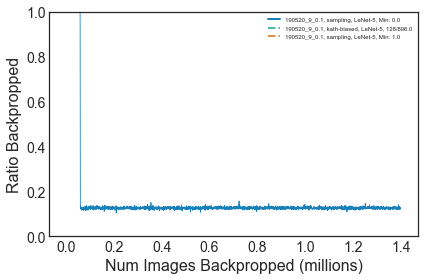

../plots/neurips//static_lr/mnist//Num-Images-Backpropped-(millions)_Test-Accuracy.pdf


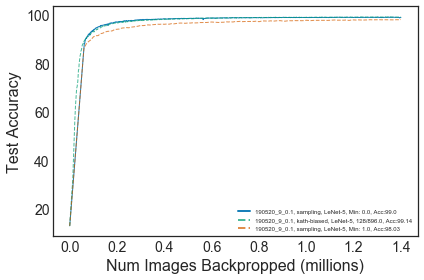

../plots/neurips//static_lr/mnist//Num-Images-Backpropped-(millions)_Test-Error.pdf


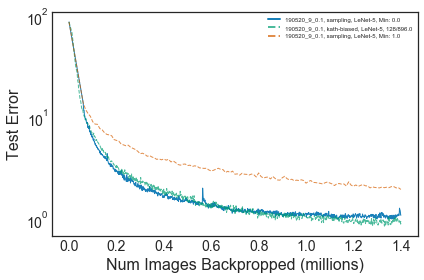

../plots/neurips//static_lr/mnist//Num-Images-Forward-Propped-(millions)_Test-Error.pdf


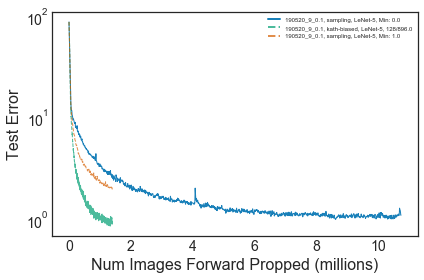

../plots/neurips//static_lr/mnist//Num-Images-Backpropped-(millions)_Test-Loss.pdf


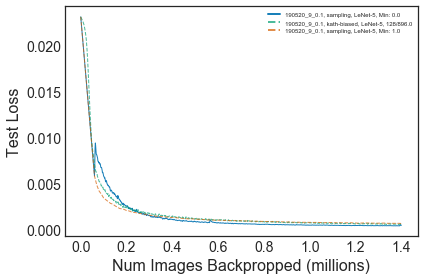

----------Baseline Error ---------------
Final error: 1.97, Forwards: 1.4, Backwards: 1.4
----------SB Error ---------------
Final error: 1.0, Forwards: 8.619971, Backwards: 1.134316
----------Kath-biased Error ---------------
Final error: 0.86, Forwards: 1.330688, Backwards: 1.330688
----------Kath-biased Baseline Error ---------------
Final error: 1.97, Forwards: 1.4, Backwards: 1.4
----------Baseline Speedup ---------------
Baseline targets: 1.97-1.97
Baseline @ 2X 1.0-1.0
Baseline targets: 1.97-1.97
Baseline @ 10X 1.0-1.0
../plots/neurips//static_lr/mnist//speedupsBaseline.pdf
----------SB Speedup ---------------
SB targets: 1.97-1.97
SB @ 2X 1.59-1.59
SB targets: 1.97-1.97
SB @ 10X 3.02-3.02
../plots/neurips//static_lr/mnist//speedupsSB.pdf
----------Kath-biased Speedup ---------------
Kath-biased targets: 1.97-1.97
Kath-biased @ 2X 1.33-1.33
Kath-biased targets: 1.97-1.97
Kath-biased @ 10X 2.58-2.58
../plots/neurips//static_lr/mnist//speedupsKath-biased.pdf


<Figure size 432x288 with 0 Axes>

In [41]:
# MNIST

plot_home_dir = "../plots"
experiment_dir = "../data/output/mnist/"

plot_home_dir = "../plots/neurips/"
plot_dir = "{}/static_lr/mnist/".format(plot_home_dir)

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = [
                    "190520_9_0.1",
                    "190520_9_0.1",
                    "190520_9_0.1",
                    ]

candidate_labels = [
                    "Baseline",
                    "SB",
                    "Kath-biased",
                   ]
filenames = [
    "sampling_mnist_LeNet-5_1_128_1024_0.0005_trial1_seed1337_v2", 
    "sampling_mnist_LeNet-5_0_128_1024_0.0005_trial1_seed1337_v2", 
    "kath-biased_mnist_LeNet-5_1_128_896_0.0005_trial1_seed1337_v2",

]
kath_selectivities = [0, 0, 896/128.]

experimental_filepaths = []
experimental_labels = []
baseline_filepath = None
target_errors = range(2, 12)
target_errors = [1.97]


if True:
    plot_experiments(list(set(experiment_names)),
                     experiment_dir,
                     plot_dir,
                     strategies = ["sampling", "kath-biased"],
                     trials=[1])
if True:
    for experiment_name, filename, experimental_label in zip(experiment_names, filenames, candidate_labels):
        filedir = os.path.join(experiment_dir, experiment_name)
        filepath = os.path.join(filedir, filename)
        experimental_filepaths.append(filepath)
        experimental_labels.append(experimental_label)

    filepath = os.path.join(experiment_dir, "190520_9_0.1", 
                            "sampling_mnist_LeNet-5_1_128_1024_0.0005_trial1_seed1337_v2")
    baseline_filepath = filepath

    max_alpha = 10
    final_bps = 1.4
    plot_wallclock(plot_dir, target_errors, experimental_filepaths, baseline_filepath, experimental_labels, final_bps, max_alpha, kath_selectivities)



=====================0========================
kath-biased_cifar100_wideresnet_0_64_256_0.0005_trial1_seed1337_v2
kath-biased_cifar100_wideresnet_0_64_256_0.0005_trial1_seed1337_v2
sampling_cifar100_wideresnet_0_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar100_wideresnet_0_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2
../plots/neurips//static_lr/cifar100//Num-Images-Backpropped-(millions)_Ratio-Backpropped.pdf


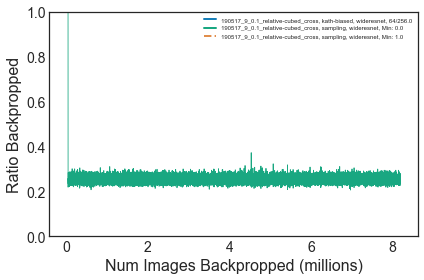

../plots/neurips//static_lr/cifar100//Num-Images-Backpropped-(millions)_Test-Accuracy.pdf


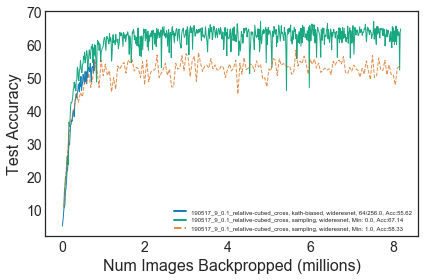

../plots/neurips//static_lr/cifar100//Num-Images-Backpropped-(millions)_Test-Error.pdf


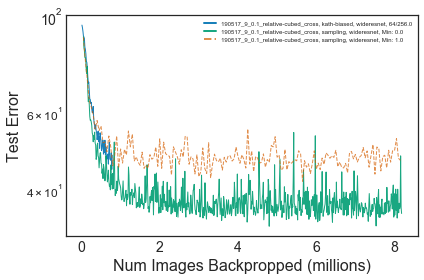

../plots/neurips//static_lr/cifar100//Num-Images-Forward-Propped-(millions)_Test-Error.pdf


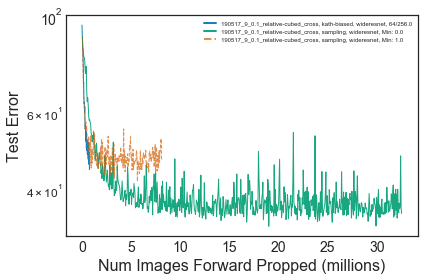

../plots/neurips//static_lr/cifar100//Num-Images-Backpropped-(millions)_Test-Loss.pdf


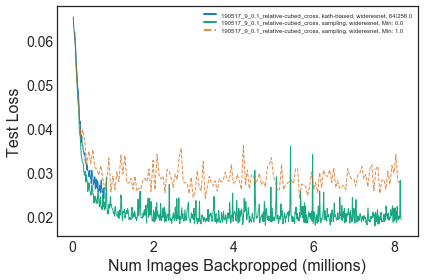

----------SB Error ---------------
Final error: 32.86, Forwards: 19.0, Backwards: 4.797676
----------Baseline Error ---------------
Final error: 41.67, Forwards: 5.65, Backwards: 5.65
----------Kath-Biased Error ---------------
Final error: 44.38, Forwards: 0.77472, Backwards: 0.77472
----------Kath-Biased Baseline Error ---------------
Final error: 41.67, Forwards: 5.65, Backwards: 5.65
----------SB Speedup ---------------
SB targets: 44.4-44.4
SB @ 2X 2.3-2.3
SB targets: 44.4-44.4
SB @ 10X 3.51-3.51
../plots/neurips//static_lr/cifar100//speedupsSB.pdf
----------Baseline Speedup ---------------
Baseline targets: 44.4-44.4
Baseline @ 2X 1.0-1.0
Baseline targets: 44.4-44.4
Baseline @ 10X 1.0-1.0
../plots/neurips//static_lr/cifar100//speedupsBaseline.pdf
=====================1========================
kath-biased_cifar100_wideresnet_0_64_256_0.0005_trial1_seed1337_v2
kath-biased_cifar100_wideresnet_0_64_256_0.0005_trial1_seed1337_v2
sampling_cifar100_wideresnet_0_64_0.0_0.0005_trial1_seed

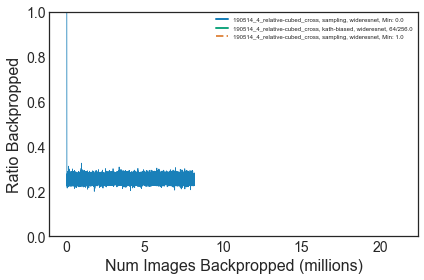

../plots/neurips//forwardlr_slow/cifar100//Num-Images-Backpropped-(millions)_Test-Accuracy.pdf


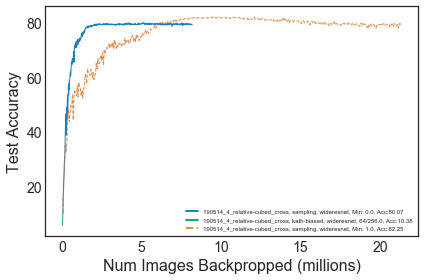

../plots/neurips//forwardlr_slow/cifar100//Num-Images-Backpropped-(millions)_Test-Error.pdf


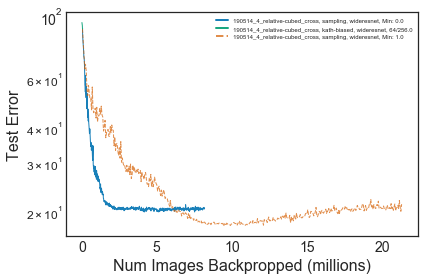

../plots/neurips//forwardlr_slow/cifar100//Num-Images-Forward-Propped-(millions)_Test-Error.pdf


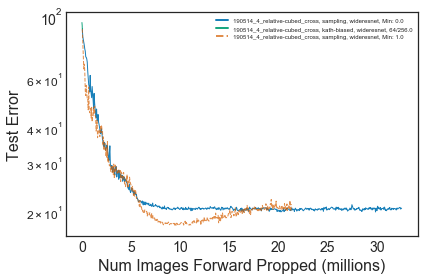

../plots/neurips//forwardlr_slow/cifar100//Num-Images-Backpropped-(millions)_Test-Loss.pdf


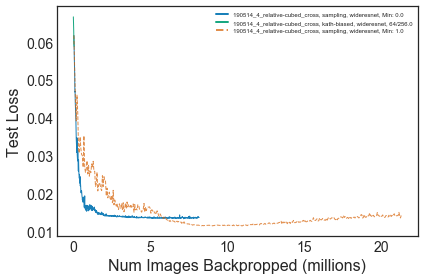

----------SB Error ---------------
Final error: 19.93, Forwards: 16.45, Backwards: 4.159345
----------Baseline Error ---------------
Final error: 17.75, Forwards: 9.45, Backwards: 9.45
----------Baseline Baseline Error ---------------
Final error: 17.75, Forwards: 9.45, Backwards: 9.45
----------SB Speedup ---------------
SB targets: 22-32
SB @ 2X 1.78-2.08
SB targets: 22-32
SB @ 10X 2.74-3.23
../plots/neurips//forwardlr_slow/cifar100//speedupsSB.pdf
----------Baseline Speedup ---------------
Baseline targets: 22-32
Baseline @ 2X 1.0-1.0
Baseline targets: 22-32
Baseline @ 10X 1.0-1.0
../plots/neurips//forwardlr_slow/cifar100//speedupsBaseline.pdf
=====================2========================
sampling_cifar100_wideresnet_0_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar100_wideresnet_0_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2
../plots/neurips//forwardlr_superslow/cifa

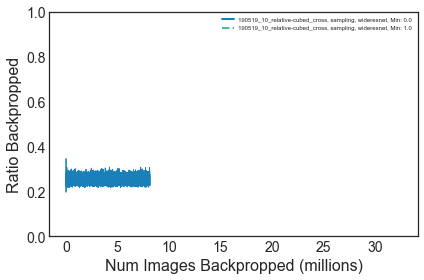

../plots/neurips//forwardlr_superslow/cifar100//Num-Images-Backpropped-(millions)_Test-Accuracy.pdf


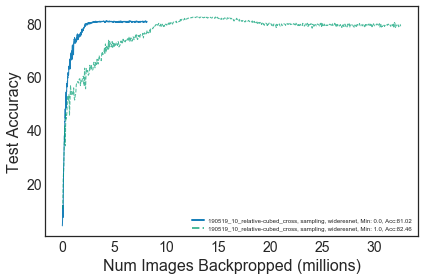

../plots/neurips//forwardlr_superslow/cifar100//Num-Images-Backpropped-(millions)_Test-Error.pdf


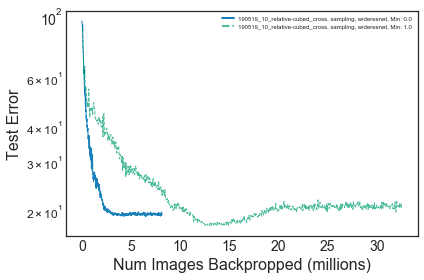

../plots/neurips//forwardlr_superslow/cifar100//Num-Images-Forward-Propped-(millions)_Test-Error.pdf


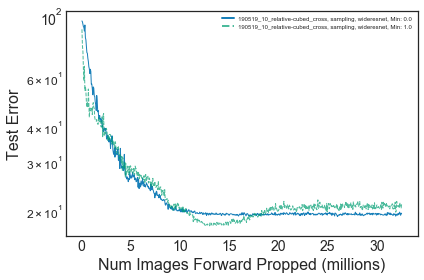

../plots/neurips//forwardlr_superslow/cifar100//Num-Images-Backpropped-(millions)_Test-Loss.pdf


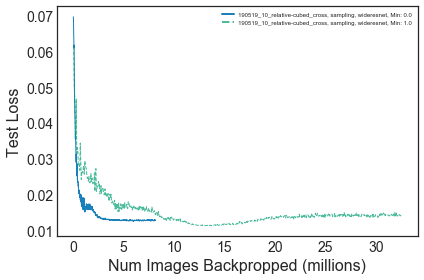

----------SB Error ---------------
Final error: 18.98, Forwards: 26.0, Backwards: 6.509186
----------Baseline Error ---------------
Final error: 17.54, Forwards: 12.9, Backwards: 12.9
----------Baseline Baseline Error ---------------
Final error: 17.54, Forwards: 12.9, Backwards: 12.9
----------SB Speedup ---------------
SB targets: 21-31
SB @ 2X 1.95-2.65
SB targets: 21-31
SB @ 10X 3.07-4.16
../plots/neurips//forwardlr_superslow/cifar100//speedupsSB.pdf
----------Baseline Speedup ---------------
Baseline targets: 21-31
Baseline @ 2X 1.0-1.0
Baseline targets: 21-31
Baseline @ 10X 1.0-1.0
../plots/neurips//forwardlr_superslow/cifar100//speedupsBaseline.pdf


<Figure size 432x288 with 0 Axes>

In [44]:
# CIFAR100

plot_home_dir = "../plots/neurips/"
experiment_dir = "../data/output/cifar100/"


for case in [0, 1, 2]:
#for case in [0]:

    # Static
    print("====================={}========================".format(case))
    if case == 0: 
        plot_dir = "{}/static_lr/cifar100/".format(plot_home_dir)
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)

        experiment_names = ["190517_9_0.1_relative-cubed_cross", "190517_9_0.1_relative-cubed_cross", "190517_9_0.1_relative-cubed_cross"]
        filenames = ["sampling_cifar100_wideresnet_0_64_0.0_0.0005_trial1_seed1337_v2",
                     "sampling_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2",
                     "kath-biased_cifar100_wideresnet_0_64_256_0.0005_trial1_seed1337_v2",
                    ]
        candidate_labels = ["SB", "Baseline", "Kath-Biased"]
        target_errors = range(48, 59)
        target_errors = [44.4]

        kath_selectivities = [0, 0]
        run_speedup_analysis=True
        final_bps = 6


    # Gradual, ForwardLR
    if case == 1: 
        plot_dir = "{}/forwardlr_slow/cifar100/".format(plot_home_dir)
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)

        experiment_names = ["190514_4_relative-cubed_cross", "190514_4_relative-cubed_cross"]
        filenames = ["sampling_cifar100_wideresnet_0_64_0.0_0.0005_trial1_seed1337_v2",
                     "sampling_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2",
                    ]
        candidate_labels = ["SB",
                            "Baseline",
                           ]
        target_errors = range(22, 33)
        run_speedup_analysis=True
        final_bps = 9

    # Gradual, ForwardLR, SuperSlow
    if case == 2: 
        plot_dir = "{}/forwardlr_superslow/cifar100/".format(plot_home_dir)
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)

        experiment_names = ["190519_10_relative-cubed_cross", "190519_10_relative-cubed_cross"]
        filenames = ["sampling_cifar100_wideresnet_0_64_0.0_0.0005_trial1_seed1337_v2",
                     "sampling_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2",
                    ]
        candidate_labels = ["SB",
                            "Baseline",
                           ]
        target_errors = range(21, 32)
        run_speedup_analysis=True
        kath_selectivities = [0, 0]
        final_bps = 3
        
    experimental_filepaths = []
    experimental_labels = []
    baseline_filepath = None

    if True:
        plot_experiments(list(set(experiment_names)),
                         experiment_dir,
                         plot_dir,
                         trials=[1])
                         #target_errors = target_errors)
    if run_speedup_analysis:
        for experiment_name, filename, experimental_label in zip(experiment_names, filenames, candidate_labels):
            filedir = os.path.join(experiment_dir, experiment_name)
            filepath = os.path.join(filedir, filename)
            experimental_filepaths.append(filepath)
            experimental_labels.append(experimental_label)

        experiment_name = experiment_names[0]
        filepath = os.path.join(experiment_dir, experiment_name,
                                "sampling_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2")
        baseline_filepath = filepath

        max_alpha = 10
        plot_wallclock(plot_dir, target_errors, experimental_filepaths, baseline_filepath, experimental_labels, final_bps, max_alpha, kath_selectivities)



=====================0========================
kath-biased_svhn_resnet_1_128_512_0.0005_trial1_seed1337_v2
kath-biased_svhn_resnet_1_128_512_0.0005_trial1_seed1337_v2
sampling_svhn_resnet_0_128_1024_0.0005_trial1_seed1337_v2
sampling_svhn_resnet_0_128_1024_0.0005_trial1_seed1337_v2
sampling_svhn_resnet_1_128_1024_0.0005_trial1_seed1337_v2
sampling_svhn_resnet_1_128_1024_0.0005_trial1_seed1337_v2
../plots/neurips//forwardlr_slow/svhn//Num-Images-Backpropped-(millions)_Ratio-Backpropped.pdf


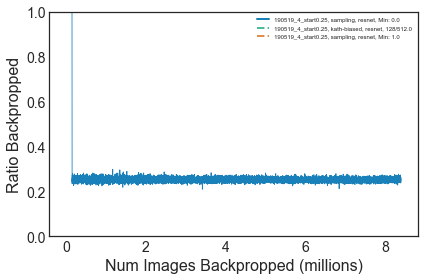

../plots/neurips//forwardlr_slow/svhn//Num-Images-Backpropped-(millions)_Test-Accuracy.pdf


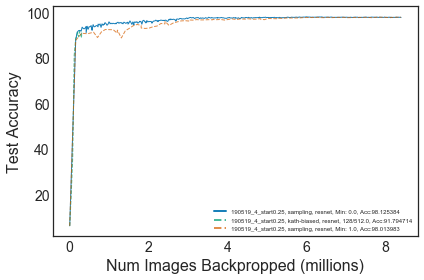

../plots/neurips//forwardlr_slow/svhn//Num-Images-Backpropped-(millions)_Test-Error.pdf


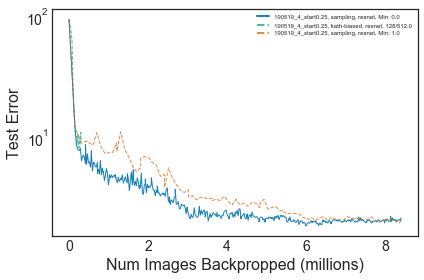

../plots/neurips//forwardlr_slow/svhn//Num-Images-Forward-Propped-(millions)_Test-Error.pdf


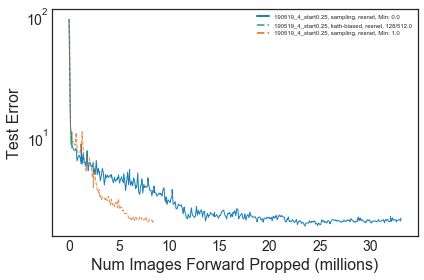

../plots/neurips//forwardlr_slow/svhn//Num-Images-Backpropped-(millions)_Test-Loss.pdf


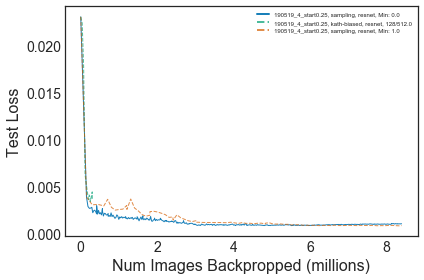

----------SB Error ---------------
Final error: 1.874616, Forwards: 23.466744, Backwards: 5.993631
----------Baseline Error ---------------
Final error: 1.986017, Forwards: 8.357044, Backwards: 8.357044
----------Kath-Biased Error ---------------
Final error: 8.205286, Forwards: 0.251008, Backwards: 0.251008
----------Kath-Biased Baseline Error ---------------
Final error: 1.986017, Forwards: 8.357044, Backwards: 8.357044
----------SB Speedup ---------------
SB targets: 3-13
SB @ 2X 0.83-3.16
SB targets: 3-13
SB @ 10X 1.0-4.2
../plots/neurips//forwardlr_slow/svhn//speedupsSB.pdf
----------Baseline Speedup ---------------
Baseline targets: 3-13
Baseline @ 2X 1.0-1.0
Baseline targets: 3-13
Baseline @ 10X 1.0-1.0
../plots/neurips//forwardlr_slow/svhn//speedupsBaseline.pdf
----------Kath-Biased Speedup ---------------
Kath-Biased targets: 9-13
Kath-Biased @ 2X 0.5-1.5
Kath-Biased targets: 9-13
Kath-Biased @ 10X 0.79-2.36
../plots/neurips//forwardlr_slow/svhn//speedupsKath-Biased.pdf
======

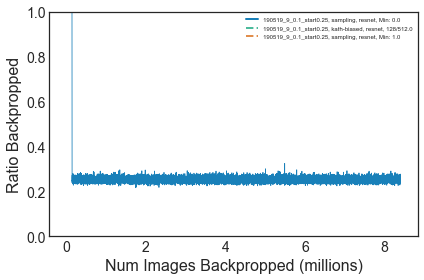

../plots/neurips//static_lr/svhn//Num-Images-Backpropped-(millions)_Test-Accuracy.pdf


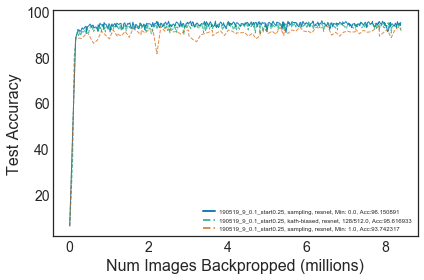

../plots/neurips//static_lr/svhn//Num-Images-Backpropped-(millions)_Test-Error.pdf


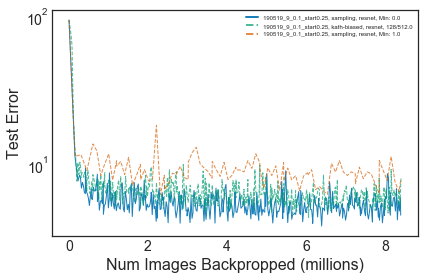

../plots/neurips//static_lr/svhn//Num-Images-Forward-Propped-(millions)_Test-Error.pdf


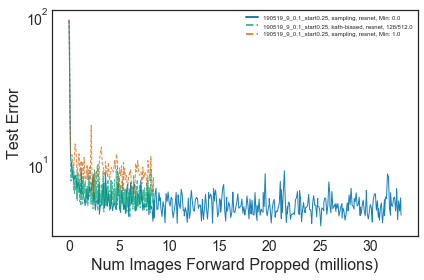

../plots/neurips//static_lr/svhn//Num-Images-Backpropped-(millions)_Test-Loss.pdf


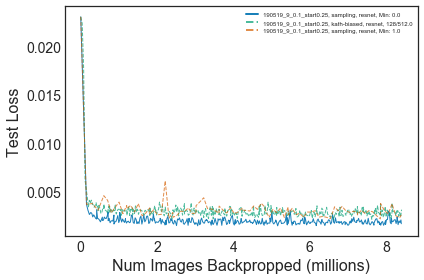

----------SB Error ---------------
Final error: 3.849109, Forwards: 25.079908, Backwards: 6.39756
----------Baseline Error ---------------
Final error: 6.257683, Forwards: 2.313164, Backwards: 2.313164
----------Kath-Biased Error ---------------
Final error: 4.383067, Forwards: 6.06656, Backwards: 6.06656
----------Kath-Biased Baseline Error ---------------
Final error: 6.257683, Forwards: 2.313164, Backwards: 2.313164
----------SB Speedup ---------------
SB targets: 6.26-6.26
SB @ 2X 2.79-2.79
SB targets: 6.26-6.26
SB @ 10X 3.96-3.96
../plots/neurips//static_lr/svhn//speedupsSB.pdf
----------Baseline Speedup ---------------
Baseline targets: 6.26-6.26
Baseline @ 2X 1.0-1.0
Baseline targets: 6.26-6.26
Baseline @ 10X 1.0-1.0
../plots/neurips//static_lr/svhn//speedupsBaseline.pdf
----------Kath-Biased Speedup ---------------
Kath-Biased targets: 6.26-6.26
Kath-Biased @ 2X 1.53-1.53
Kath-Biased targets: 6.26-6.26
Kath-Biased @ 10X 2.41-2.41
../plots/neurips//static_lr/svhn//speedupsKath-B

<Figure size 432x288 with 0 Axes>

In [45]:
# svhn

plot_home_dir = "../plots/neurips/"
experiment_dir = "../data/output/svhn/"

for case in [0, 1]:
#for case in [1]:

    # gradual, forwardlr
    print("====================={}========================".format(case))

    if case == 0:
        plot_dir = "{}/forwardlr_slow/svhn/".format(plot_home_dir)

        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)

        experiment_names = ["190519_4_start0.25", "190519_4_start0.25", "190519_4_start0.25"]
        filenames = ["sampling_svhn_resnet_0_128_1024_0.0005_trial1_seed1337_v2",
                     "sampling_svhn_resnet_1_128_1024_0.0005_trial1_seed1337_v2",
                     "kath-biased_svhn_resnet_1_128_512_0.0005_trial1_seed1337_v2"
                    ]
        candidate_labels = [
                            "SB",
                            "Baseline",
                            "Kath-Biased",
                           ]
        target_errors = range(3, 14)
        kath_selectivities = [0, 0, 512/128.]
        final_bps = 1
        run_speedup_analysis = True

    # static
    if case == 1:
        plot_dir = "{}/static_lr/svhn/".format(plot_home_dir)
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)

        experiment_names = [
                            "190519_9_0.1_start0.25",
                            "190519_9_0.1_start0.25",
                            "190519_9_0.1_start0.25",
                           ]

        filenames = ["sampling_svhn_resnet_0_128_1024_0.0005_trial1_seed1337_v2",
                     "sampling_svhn_resnet_1_128_1024_0.0005_trial1_seed1337_v2",
                     "kath-biased_svhn_resnet_1_128_512_0.0005_trial1_seed1337_v2"
                    ]
        candidate_labels = [
                            "SB",
                            "Baseline",
                            "Kath-Biased"
                           ]
        
        target_errors = range(9, 20)
        target_errors = [6.26]
        kath_selectivities = [0, 0, 512/128.]
        final_bps = 8
        run_speedup_analysis = True

    experimental_filepaths = []
    experimental_labels = []
    baseline_filepath = None

    if True:
        plot_experiments(list(set(experiment_names)),
                         experiment_dir,
                         plot_dir,
                         trials=[1],
                        )
                         #target_errors = target_errors)
    if run_speedup_analysis:
        for experiment_name, filename, experimental_label in zip(experiment_names, filenames, candidate_labels):
            filedir = os.path.join(experiment_dir, experiment_name)
            filepath = os.path.join(filedir, filename)
            experimental_filepaths.append(filepath)
            experimental_labels.append(experimental_label)

        experiment_name = experiment_names[0]
        filepath = os.path.join(experiment_dir, experiment_name, filenames[1])
        baseline_filepath = filepath

        max_alpha = 10
        plot_wallclock(plot_dir, target_errors, experimental_filepaths, baseline_filepath, experimental_labels, final_bps, max_alpha, kath_selectivities)



In [46]:
# CIFAR10 sweeps


plot_home_dir = "../plots/neurips/"
experiment_dir = "../data/output/cifar10/"


# nets
if True:
    nets = ["mobilenetv2", "resnet", "densenet"]
    for net in nets:
        print("-----------------{}-------------------".format(net))
        plot_dir = "{}/sweeps/nets/{}".format(plot_home_dir, net)
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)
        experiment_names = ["190516_9_0.1", "190516_9_0.1_nets"]
        
#         plot_experiments(experiment_names,
#                              experiment_dir,
#                              plot_dir,
#                              nets = [net],
#                              strategies=["sampling"],
#                              trials=[1])
        
        if net == "mobilenetv2":
            experiment_names = ["190516_9_0.1", "190516_9_0.1"]
            filename = "sampling_cifar10_mobilenetv2_0_128_1024_0.0005_trial1_seed1337_v2"
            baseline = "sampling_cifar10_mobilenetv2_1_128_1024_0.0005_trial1_seed1337_v2"
            final_bps = 6
            continue

        elif net == "resnet":
            experiment_names = ["190516_9_0.1_nets", "190516_9_0.1_nets",]
            filename = "sampling_cifar10_resnet_0_128_1024_0.0005_trial1_seed1337_v2"
            baseline = "sampling_cifar10_resnet_1_128_1024_0.0005_trial1_seed1337_v2"
            final_bps = 2
            target_errors = range(17, 33)


        elif net == "densenet":
            experiment_names = ["190516_9_0.1_nets", "190516_9_0.1_nets",]
            filename = "sampling_cifar10_densenet_0_64_1024_0.0005_trial1_seed1337_v2"
            baseline = "sampling_cifar10_densenet_1_64_1024_0.0005_trial1_seed1337_v2"
            final_bps = 2
            target_errors = range(21, 27)

        else:
            print("This is a problem")


        filenames = [baseline,
                     filename,
                    ]
        candidate_labels = ["Baseline",
                            "SB",
                           ]
        kath_selectivities = [0, 0]
        
        if True:
            experimental_filepaths = []
            experimental_labels = []
            for experiment_name, filename, experimental_label in zip(experiment_names, filenames, candidate_labels):
                filedir = os.path.join(experiment_dir, experiment_name)
                filepath = os.path.join(filedir, filename)
                experimental_filepaths.append(filepath)
                experimental_labels.append(experimental_label)

            experiment_name = experiment_names[0]
            filepath = os.path.join(experiment_dir, experiment_name, baseline)
            baseline_filepath = filepath

            max_alpha = 10
            plot_wallclock(plot_dir, target_errors, experimental_filepaths, baseline_filepath, experimental_labels, final_bps, max_alpha, kath_selectivities)
        
        
# Label error
if False:
    errors = [0.001, 0.01, 0.1]
    for error in errors:
        plot_dir = "{}/sweeps/labelerror/{}".format(plot_home_dir, error)
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)
        experiment_names = ["190520_labelerror_shuffle{}".format(error)]

        plot_experiments(experiment_names,
                         experiment_dir,
                         plot_dir,
                         strategies=["sampling"],
                         trials=[1])
    
# Attribution
if False:
    experiment_names = ["190518_4", "190518_4_kath"]
    plot_dir = "{}/sweeps/attribution/gradual/".format(plot_home_dir)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plot_experiments(experiment_names,
                         experiment_dir,
                         plot_dir,
                         nets=["mobilenetv2"],
                         strategies=["sampling", "topk", "kath-biased"],
                         trials=[1])
    
    
    experiment_names = ["190516_9_0.1"]
    plot_dir = "{}/sweeps/attribution/static/".format(plot_home_dir)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plot_experiments(experiment_names,
                         experiment_dir,
                         plot_dir,
                         nets=["mobilenetv2"],
                         strategies=["sampling", "topk", "kath-biased"],
                         trials=[1])

            



-----------------mobilenetv2-------------------
-----------------resnet-------------------
----------Baseline Error ---------------
Final error: 12.2, Forwards: 4.7, Backwards: 4.7
----------SB Error ---------------
Final error: 8.45, Forwards: 20.0, Backwards: 5.049602
----------SB Baseline Error ---------------
Final error: 12.2, Forwards: 4.7, Backwards: 4.7
----------Baseline Speedup ---------------
Baseline targets: 17-32
Baseline @ 2X 1.0-1.0
Baseline targets: 17-32
Baseline @ 10X 1.0-1.0
../plots/neurips//sweeps/nets/resnet/speedupsBaseline.pdf
----------SB Speedup ---------------
SB targets: 17-32
SB @ 2X 0.67-1.6
SB targets: 17-32
SB @ 10X 0.96-2.38
../plots/neurips//sweeps/nets/resnet/speedupsSB.pdf
-----------------densenet-------------------
----------Baseline Error ---------------
Final error: 16.52, Forwards: 3.85, Backwards: 3.85
----------SB Error ---------------
Final error: 10.07, Forwards: 10.2, Backwards: 2.594031
----------SB Baseline Error ---------------
Final er

<Figure size 432x288 with 0 Axes>

In [47]:
plot_home_dir = "../plots/neurips/"

exp_name = "confidences"
plot_dir = "{}/{}".format(plot_home_dir, exp_name)
if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

labels = [OURSYSTEM,
          BASELINE]

prefix = "../plots/batch_stats/190516_9_0.1/data/"
files = [
         "{}/{}".format(prefix, "sampling_cifar10_mobilenetv2_0_128_1024_0.0005_trial1_seed1337_target_confidences.pickle_epoch160_2040836backpropped.txt"),
         "{}/{}".format(prefix, "sampling_cifar10_mobilenetv2_1_128_1024_0.0005_trial1_seed1337_target_confidences.pickle_epoch40_2000000backpropped.txt"),
]
colors = [SB_COLOR, BASELINE_COLOR]

plot_percentiles(plot_dir, files, labels, colors)

../plots/neurips//confidences/Target Confidence.pdf
../plots/neurips//confidences/Percent Correct.pdf


<Figure size 432x288 with 0 Axes>